In [1]:
import pandas as pd
import datetime
import numpy as np
import seaborn as sns
#import geopandas as gpd
import matplotlib.pyplot as plt
#note, geopandas and pyspark now installed

In [2]:
df= pd.read_csv('immo_data.csv.zip')
#https://www.kaggle.com/datasets/corrieaar/apartment-rental-offers-in-germany?resource=download

An overview of missing values

<AxesSubplot:>

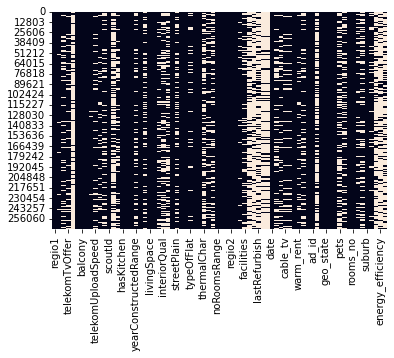

In [27]:
sns.heatmap(df.isnull(), cbar=False)

### At first glance...

There is LOTS of missing data (likely not due to the collectors, rather that there are fields which are not required on the site...since I applied personally to live in over 200 flats in germany and probably read at least 1000 postings by now, some I will fill with values based on what seems likely to me, and others I will make into subsets since I want to do analyses with most of the features in this dataset)

the descriptions and facilities are in german (which is fine, since I understand)- could be helpful to get a listing fo the most common or important /  appealing facilities (Badewanne, Fahrstuhl, keller, Parkett/ Diele, neu saniert) to compare with the price point and region.. also interesting with fresher (more recent) data to look at gas heating and see if properties not cheaper- going to fully dissect and clean that part up later

also geo features = map visualisations? :~)

In [4]:
df.columns 
#telekom tv offer: price for cable TV

#regio3 = town
#geo_krs = geo _kreis = municipality = regio2?? (smaller municipality, COULD differ )
#geo_bln = geo_bundesland = state = regio1 (make a col for each and then see if all vals same..?) 

#range features nothing missing...how are the NaNs binned, if these are supposed to be binned features? 

#df['']
#df[''].unique()

Index(['regio1', 'serviceCharge', 'heatingType', 'telekomTvOffer',
       'telekomHybridUploadSpeed', 'newlyConst', 'balcony', 'picturecount',
       'pricetrend', 'telekomUploadSpeed', 'totalRent', 'yearConstructed',
       'scoutId', 'noParkSpaces', 'firingTypes', 'hasKitchen', 'geo_bln',
       'cellar', 'yearConstructedRange', 'baseRent', 'houseNumber',
       'livingSpace', 'geo_krs', 'condition', 'interiorQual', 'petsAllowed',
       'street', 'streetPlain', 'lift', 'baseRentRange', 'typeOfFlat',
       'geo_plz', 'noRooms', 'thermalChar', 'floor', 'numberOfFloors',
       'noRoomsRange', 'garden', 'livingSpaceRange', 'regio2', 'regio3',
       'description', 'facilities', 'heatingCosts', 'energyEfficiencyClass',
       'lastRefurbish', 'electricityBasePrice', 'electricityKwhPrice', 'date'],
      dtype='object')

## Wrangle

Rename cols according to guidelines, and make new df to export later (once clean) with relevant cols

In [5]:
df['heating_fuel'] = df['firingTypes']
df['heating_type']=df['heatingType']
df['cable_tv'] = df['telekomTvOffer']
df['net_speed'] = df['telekomUploadSpeed']
df['new'] = df['newlyConst']
df['warm_rent'] = df['totalRent']
df['construction_yr'] = df['yearConstructed']
df['cold_rent'] = df['baseRent']
df['ad_id'] = df['scoutId'] #rmv no Id? 
df['parkingspot_no'] = df['noParkSpaces'] #NaN to 0
df['heating_fuel'] = df['firingTypes']
df['kitchen'] = df['hasKitchen']
df['geo_state'] = df['geo_bln']
df['sq_m'] = df['livingSpace']
df['geo_municipality'] = df['geo_krs']
df['pets'] = df['petsAllowed']
df['street_name'] = df['streetPlain']#be careful not to confused with street (not cleaned)
df['geo_postcode'] = df['geo_plz']
df['rooms_no'] = df['noRooms']
df['level'] = df['floor'] 
df['buildings_floors'] = df['numberOfFloors']
df['suburb'] = df['regio3']
df['flat_type'] = df['typeOfFlat']
df['heating_cost'] = df['heatingCosts']
df['energy_efficiency'] = df['energyEfficiencyClass']
df['last_refurbish'] = df['lastRefurbish'] #datatype!! beware (float, but year actually)

#### New df: with changed feature names, and relevant features

In [28]:
rentals = df[[ 'date', 'ad_id','geo_state', 'geo_municipality', 'suburb', 'sq_m','condition','rooms_no', 'warm_rent','cold_rent', 'level', 'kitchen', 'construction_yr','heating_fuel','cellar', 'parkingspot_no','street_name', 'lift','flat_type', 'buildings_floors', 'garden','description','facilities','heating_cost', 'energy_efficiency', 'last_refurbish']]

<AxesSubplot:>

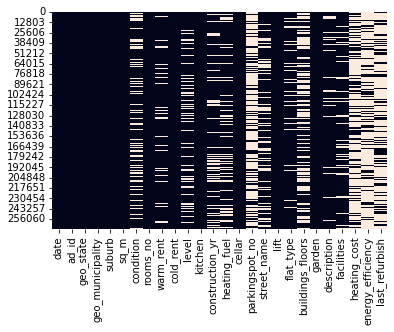

In [29]:
sns.heatmap(rentals.isnull(), cbar=False) #get rid of those without warm or cold rent? or advanced fill method? 

In [30]:
rentals.columns

Index(['date', 'ad_id', 'geo_state', 'geo_municipality', 'suburb', 'sq_m',
       'condition', 'rooms_no', 'warm_rent', 'cold_rent', 'level', 'kitchen',
       'construction_yr', 'heating_fuel', 'cellar', 'parkingspot_no',
       'street_name', 'lift', 'flat_type', 'buildings_floors', 'garden',
       'description', 'facilities', 'heating_cost', 'energy_efficiency',
       'last_refurbish'],
      dtype='object')

In [8]:
rentals.dtypes #look at dtypes to determine what needs to be changed

date                 object
ad_id                 int64
geo_state            object
geo_municipality     object
suburb               object
sq_m                float64
condition            object
rooms_no            float64
warm_rent           float64
cold_rent           float64
level               float64
kitchen                bool
construction_yr     float64
heating_fuel         object
cellar                 bool
parkingspot_no      float64
street_name          object
lift                   bool
flat_type            object
buildings_floors    float64
garden                 bool
description          object
facilities           object
heating_cost        float64
dtype: object

Fine as is: bools (kitchen, lift, garden and cellar), on ice (description and facilities), all floats not below, and int ad_id

Convert: to date / year formats (date, construction_yr), to int64 (rooms_no, level, parkingspot_no, buildings_floors), to string? df['column'] = df['column'].astype('str') OR df['column'] = df['column'].astype('|S') 

### First up! Time cols
dataset limited in that, only two years are sampled, and only two months within those two years..future database will sample more frequently

keep initial date col, can compare specific months even tho diff years to see if very diff or not..

In [39]:
rentals['year'] = rentals['date'].str[-2:]

C:\Users\alexp\AppData\Local\Temp/ipykernel_11000/3261732633.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rentals['year'] = rentals['date'].str[-2:]


In [41]:
rentals['year'] = rentals['year'].map('20{}'.format)

C:\Users\alexp\AppData\Local\Temp/ipykernel_11000/2998449590.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rentals['year'] = rentals['year'].map('20{}'.format)


In [17]:
#rentals['date'].unique() #May, Oct, Feb, Sept ...therefore Spring and Autumn ?? better sampling in future.. 

array(['May19', 'Oct19', 'Feb20', 'Sep18'], dtype=object)

In [31]:
#spring/summer and autumn/winter feature
rentals['season'] = rentals['date'].str[:3]
rentals['season'].replace({"May": "Spring / Summer", "Oct": "Autumn/ Winter", "Sep": "Spring/Summer", "Feb": "Autumn/ Winter"}, inplace=True)

C:\Users\alexp\AppData\Local\Temp/ipykernel_11000/2915212350.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rentals['season'] = rentals['date'].str[:3]


In [43]:
#rentals #example index 4 is neu saniert in description, but the lister didnt fill out the field so last refurbish is NaN (in a bin it could go in the last two years at a guess)

## Dealing with the many missing values
    
Basic- condition(average), parking spot (0, if not mentioned likely doesnt have, not super important feature), flat_type (mode for region), last refurbish (mean for the region, for the town and for the state- needs to be done before heating cost and energy efficiency), Street name (mode for suburb,when none for suburb then for town)

Moderately complex (weighted means) - level, construction year (mean of region, construction year/ levels (vica versa) and cold rent), heating fuel (construction year average), building floors (at end!! mean for warm rent and levels- need to ensure not lower than level..), heating cost (mean for energy efficiency, last refurbish, heating fuel (based current prices), construction year), energy efficiency (mean of level- binned, construction year, and last refurbish BEFORE previous!)

Complex: warm rent- do some kind of machine learning to predict it, and determine which features most predictive (most important feature!) 

Binning (for the many strings): has to happen before weighted mean for warm rent (but after other fillna wrangling)

Features to be binned: condition, cold_rent, level, construction_yr, parking spot no, 

Features converted to cat vars (maybe?): heating_fuel, flat type, 

Features to investigate: sq_m (result of binning?)

# Planning 

In [10]:
#want to know what factors most predict price in different states 

In [11]:
#want to know what factors most predict price in most expensive and least two expensive places.. 

In [12]:
#want to know 